In [1]:
from qiskit.circuit.library import TwoLocal
from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import numpy as np
import matplotlib.pyplot as plt
import datetime 
from qiskit_finance.data_providers import *
import cplex
from qiskit_algorithms.utils import algorithm_globals
from qiskit_finance.applications.optimization import PortfolioDiversification
from qiskit_aer.primitives import Sampler

# Choosing a portfolio 

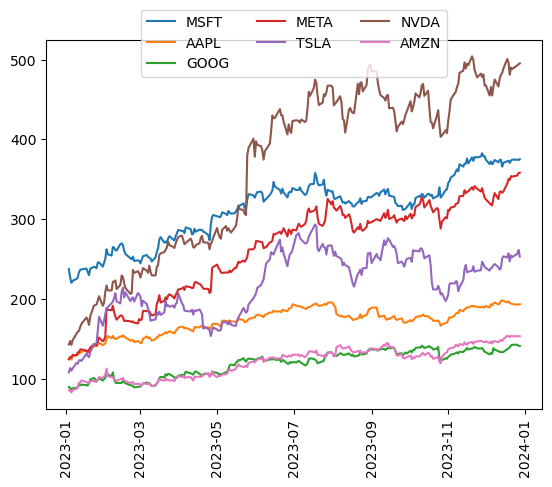

[[ 1714.62728188   687.20619574   608.84732118  2499.45909564
   1302.8104977   4167.32102253   730.99909318]
 [  687.20619574   305.94353276   243.28519475  1024.48484783
    607.03933843  1732.2072135    291.36864388]
 [  608.84732118   243.28519475   267.32503821   980.10046446
    523.31378926  1662.09863678   289.63078825]
 [ 2499.45909564  1024.48484783   980.10046446  3965.75838151
   2175.84537483  6617.23589969  1128.47496121]
 [ 1302.8104977    607.03933843   523.31378926  2175.84537483
   1760.21110942  3884.48606498   627.17822672]
 [ 4167.32102253  1732.2072135   1662.09863678  6617.23589969
   3884.48606498 11552.04059556  1935.3040978 ]
 [  730.99909318   291.36864388   289.63078825  1128.47496121
    627.17822672  1935.3040978    354.90359318]]


In [2]:
# set number of assets (= number of qubits)

## I chose the magnificent 7, which are the top 7 performing stocks in the S&P500, even though it means that my portfolio won't be well diversified
stocks = ["MSFT", "AAPL", "GOOG", "META", "TSLA", "NVDA", "AMZN"]

data = YahooDataProvider(
    tickers=stocks,
    start=datetime.datetime(2023, 1, 1),
    end=datetime.datetime(2023, 12, 31),
)
data.run()
## plots the stock progression for all 7 stocks in the year 2023
for (cnt, s) in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=3)
plt.xticks(rotation=90)
plt.show()

mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

print(data.get_covariance_matrix())

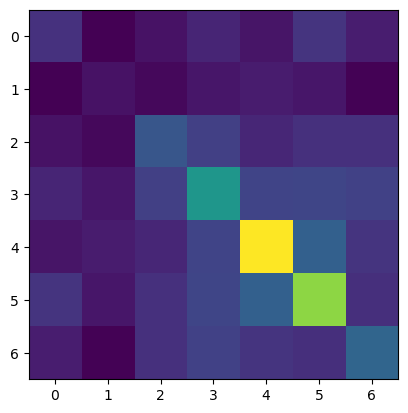

In [3]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()

### Since the covariance of these 7 stocks is very high and far from zero, it won't nessarily form a diverse portfolio. Diverse portfolios will have near 0 covariance. So I will choose 4 random stocks to represent different levels of return in the S&P 500

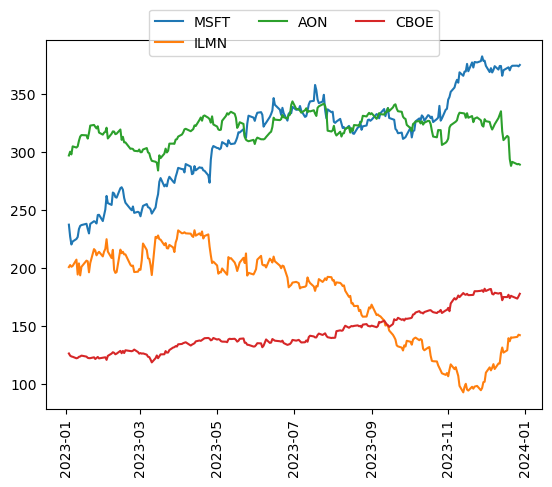

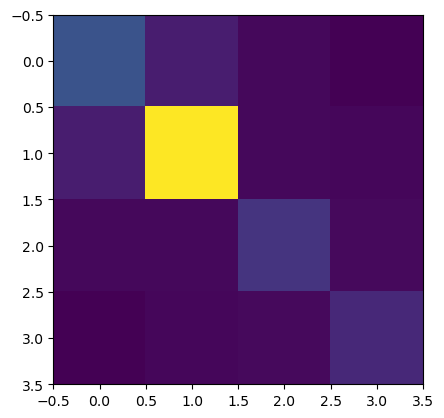

[[ 1714.62726771 -1193.31792481   230.90390176   616.01322422]
 [-1193.31792481  1625.53788307  -139.0424131   -656.10486098]
 [  230.90390176  -139.0424131    156.88797746    65.4859772 ]
 [  616.01322422  -656.10486098    65.4859772    315.03519313]]


In [4]:
# set number of assets (= number of qubits)
stocks = ["MSFT", "ILMN", "AON", "CBOE"]
## new choice of stocks with varying returns in S&P500
data = YahooDataProvider(
    tickers=["MSFT", "ILMN", "AON", "CBOE"],
    start=datetime.datetime(2023, 1, 1),
    end=datetime.datetime(2023, 12, 31),
)
data.run()
## plots the stock progression for all 7 stocks in the year 2023
for (cnt, s) in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=3)
plt.xticks(rotation=90)
plt.show()

mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()

print(data.get_covariance_matrix())

In [5]:
q = 0.5  # set risk factor
num_assets = 4
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()

In [6]:
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

In [7]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 1.], value -0.0032

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 0 1]	-0.0032		1.0000


In [8]:
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
svqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)
svqe = MinimumEigenOptimizer(svqe_mes)
result = svqe.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 1.], value -0.0032

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 0 1]	-0.0032		0.8682
 [0 1 0 1]	0.0001		0.0430
 [1 1 0 0]	-0.0003		0.0254
 [1 0 1 0]	-0.0017		0.0234
 [0 0 1 1]	-0.0012		0.0137
 [0 1 1 1]	0.0003		0.0078
 [1 1 1 0]	-0.0002		0.0068
 [0 0 0 1]	-0.0014		0.0029
 [1 0 0 0]	-0.0018		0.0029
 [1 1 0 1]	-0.0017		0.0020
 [0 1 0 0]	0.0014		0.0020
 [1 0 1 1]	-0.0030		0.0010
 [0 0 1 0]	0.0001		0.0010


In [9]:
algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=3)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 1.], value -0.0032

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 0 1]	-0.0032		0.1924
 [1 0 1 0]	-0.0017		0.1914
 [0 1 1 0]	0.0016		0.1592
 [0 0 1 1]	-0.0012		0.1504
 [1 1 0 0]	-0.0003		0.1494
 [0 1 0 1]	0.0001		0.1367
 [0 1 0 0]	0.0014		0.0029
 [0 0 1 0]	0.0001		0.0029
 [1 0 0 0]	-0.0018		0.0029
 [0 1 1 1]	0.0003		0.0029
 [1 1 1 0]	-0.0002		0.0020
 [1 1 1 1]	-0.0014		0.0020
 [0 0 0 1]	-0.0014		0.0020
 [1 0 1 1]	-0.0030		0.0010
 [1 1 0 1]	-0.0017		0.0010
 [0 0 0 0]	0.0000		0.0010


Quantum portfolio diversification

In [10]:
n = len(stocks)
rho = data.get_similarity_matrix()

In [11]:
class QuantumOptimizer:
    def __init__(self, rho, n, q):
        self.rho = rho
        self.n = n
        self.q = q
        self.pdf = PortfolioDiversification(similarity_matrix=rho, num_assets=n, num_clusters=q)
        self.qp = self.pdf.to_quadratic_program()

    # Obtains the least eigenvalue of the Hamiltonian classically
    def exact_solution(self):
        exact_mes = NumPyMinimumEigensolver()
        exact_eigensolver = MinimumEigenOptimizer(exact_mes)
        result = exact_eigensolver.solve(self.qp)
        return self.decode_result(result)

    def sampling_vqe_solution(self):
        algorithm_globals.random_seed = 100
        cobyla = COBYLA()
        cobyla.set_options(maxiter=250)
        ry = TwoLocal(n, "ry", "cz", reps=5, entanglement="full")
        svqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)
        svqe = MinimumEigenOptimizer(svqe_mes)
        result = svqe.solve(self.qp)
        return self.decode_result(result)

    def qaoa_solution(self):
        algorithm_globals.random_seed = 1234
        cobyla = COBYLA()
        cobyla.set_options(maxiter=250)
        qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=3)
        qaoa = MinimumEigenOptimizer(qaoa_mes)
        result = qaoa.solve(self.qp)
        return self.decode_result(result)

    def decode_result(self, result, offset=0):
        quantum_solution = 1 - (result.x)
        ground_level = self.qp.objective.evaluate(result.x)
        return quantum_solution, ground_level

In [12]:
# Instantiate the quantum optimizer class with parameters:
quantum_optimizer = QuantumOptimizer(rho, n, q)

In [13]:
# warnings.filterwarnings('ignore')
quantum_solution, quantum_cost = quantum_optimizer.exact_solution()
print(quantum_solution, quantum_cost)

The value could be too small. If so, set the penalty coefficient manually.
The value could be too small. If so, set the penalty coefficient manually.


[0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1.] 1.000227980319867


In [14]:
svqe_state, svqe_level = quantum_optimizer.sampling_vqe_solution()
print(svqe_state, svqe_level)

The value could be too small. If so, set the penalty coefficient manually.
The value could be too small. If so, set the penalty coefficient manually.


[0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.] 4.000614142250561


In [18]:
def visualize_solution(xc, yc, x, C, n, K, title_str):
    plt.figure()
    plt.scatter(xc, yc, s=200)
    for i in range(len(xc)):
        plt.annotate(i, (xc[i] + 0.015, yc[i]), size=16, color="r")

    plt.grid()

    for ii in range(n**2, n**2 + n):

        if x[ii] > 0:
            plt.plot(xc[ii - n**2], yc[ii - n**2], "r*", ms=20)

    for ii in range(0, n**2):

        if x[ii] > 0:
            iy = ii // n
            ix = ii % n
            plt.plot([xc[ix], xc[iy]], [yc[ix], yc[iy]], "C2")

    plt.title(title_str + " cost = " + str(int(C * 100) / 100.0))
    plt.show()

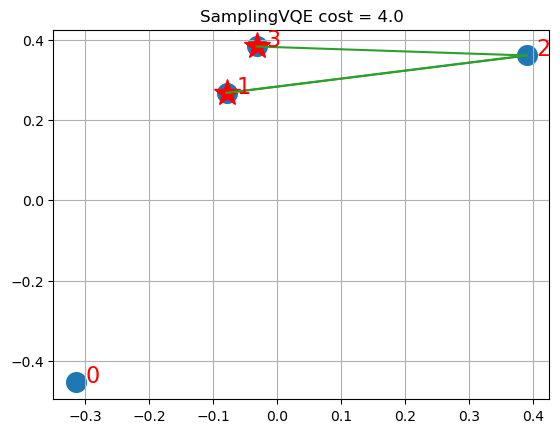

In [19]:
xc, yc = data.get_coordinates()
visualize_solution(xc, yc, svqe_state, svqe_level, n, q, "SamplingVQE")

In [ ]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright